In [1]:
%matplotlib notebook
import os
import numpy as np
import pandas as pd
import rasterio as rio
import fiona as fio
from fiona.crs import from_epsg
from pyproj import Proj, transform
import matplotlib.pyplot as plt

# read additional scripts
from scripts.clip_area import clip_area
from scripts.read_landsat_images import read_landsat_images
from scripts.show_band import show_band

In [43]:
# Prepare list of folders / dates

def prepare_directories(main_folder):
    raw_list = os.listdir(main_folder)
    prepared_list = []
    for folder in raw_list:
        if folder.startswith('LC'):
            prepared_list.append(main_folder + '/' + folder + '/')
    return prepared_list

def read_timestamp(folder):
    files = os.listdir(folder)
    for file in files:
        if file.startswith('LC') and file.endswith('MTL.txt'):
            address = folder + '/' + file
            with open(address, 'r') as f:
                for line in f:
                    line = ''.join(line.split())
                    if line.startswith('DATE_ACQUIRED='):
                        line = line.replace('DATE_ACQUIRED=', '')
                        return line

def prepare_dataframe(folders):
    # DataFrame preparation
    time_series = pd.DataFrame(folders, columns=['DIR'])
    time_series.index = time_series['DIR'].apply(lambda x: pd.to_datetime(read_timestamp(x)).date())
    time_series.index.name = 'DATE'
    time_series = time_series.sort_index()
    return time_series

folder = 'data/rasters'
dataset = prepare_directories(folder)
dataset = prepare_dataframe(dataset)
dataset

,DIR
DATE,
2013-08-05,data/rasters/LC081900232013080501T1-SC20180517...
2014-05-20,data/rasters/LC081900232014052001T1-SC20180517...
2014-07-07,data/rasters/LC081900232014070701T1-SC20180517...
2014-09-16,data/rasters/LC081910232014091601T1-SC20180517...
2015-04-21,data/rasters/LC081900232015042101T1-SC20180517...
2015-05-07,data/rasters/LC081900232015050701T1-SC20180517...
2015-07-01,data/rasters/LC081910232015070101T1-SC20180517...
2015-08-11,data/rasters/LC081900232015081101T1-SC20180517...
2015-08-18,data/rasters/LC081910232015081801T1-SC20180517...


In [3]:
# Prepare Area of Interest

def get_epsg_from_raster(raster_address):
    with rio.open(raster_address) as f:
        band_crs = f.crs
        destination_epsg = band_crs['init'][5:]
        destination_epsg = int(destination_epsg)
    return destination_epsg

In [4]:
class VectorData:
    
    def __init__(self, filename):
        self.v_file = filename
        self.geometry = {}
        self.properties = None
        self.vec_crs = None
        self.vec_schema = None
        
    def get_vector_data(self, parameters='all', write_params=True):
        """input 1: parameters (string)
        parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'
        'all': returns tuple with geometry, properties, crs and schema;
        'none': does not return anything;
        'geometry', 'properties', 'crs' or 'schema': returns chosen parameter.
        input 2: write_params (bool)
        write_params: True, False
        True: store all parameters in the object
        False: do not store anything in the object
        output: chosen parameters as a dict"""
        
        with fio.open(vector_file, 'r') as masking_region:
            geometry = [feature["geometry"] for feature in masking_region]
            properties = [feature['properties'] for feature in masking_region]
            vec_crs = masking_region.crs
            vec_schema = masking_region.schema
        
        if write_params:
            print('--- Object geometry, properties, crs and schema updated ---')
            self.geometry = geometry
            self.properties = properties
            self.vec_crs = vec_crs
            self.vec_schema = vec_schema
        else:
            print('--- Object parameters not updated ---')
            
        output_dict = {'all': ({'geometry': geometry, 'properties': properties, 'crs': vec_crs, 'scheme': vec_schema}),
                      'none': 0,
                      'geometry': geometry,
                      'properties': properties,
                      'crs': vec_crs,
                      'schema': vec_schema}
        try:
            return output_dict[parameters]
        except KeyError:
            raise KeyError("Parameter not available. Available parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'")
      
    def reproject_geometry(self, destination_epsg, update=False):
        try:
            destination_crs = from_epsg(destination_epsg)
            proj_crs_in = Proj(self.vec_crs)
            coordinates_list = self.geometry[0]['coordinates'][0]
        except RuntimeError:
            raise ValueError('Given EPSG is wrong or it is not stored in fiona to run from_epsg method')
        except KeyError:
            raise ValueError('You must update your object parameters by get_vector_data method with write_params set to True.')
        proj_crs_out = Proj(init = destination_crs['init'])
        coordinates_array = np.asarray(coordinates_list)
        projected_g = []
        
        for g in coordinates_array:
            transformed = transform(proj_crs_in, proj_crs_out, g[0], g[1])
            points = (transformed[0], transformed[1],)
            projected_g.append(points)
        geometry_dict = {'coordinates': [projected_g], 'type': 'Polygon'}
        
        if update:
            self.geometry = [geometry_dict]
            
        return [geometry_dict]
    
    def show_vector_data(self, geometry=None):
        if geometry:
            g = geometry
        else:
            g = self.geometry
            
        try:
            coordinates_list = g[0]['coordinates'][0]
        except KeyError:
            raise ValueError(
                'Geometry is not defined. Please, update geometry with get_vector_data method or provide valid geometry object to the method.')
            
        coordinates_array = np.asarray(coordinates_list)
        plt.figure()
        plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
        plt.show()

--- Object geometry, properties, crs and schema updated ---


<IPython.core.display.Javascript object>


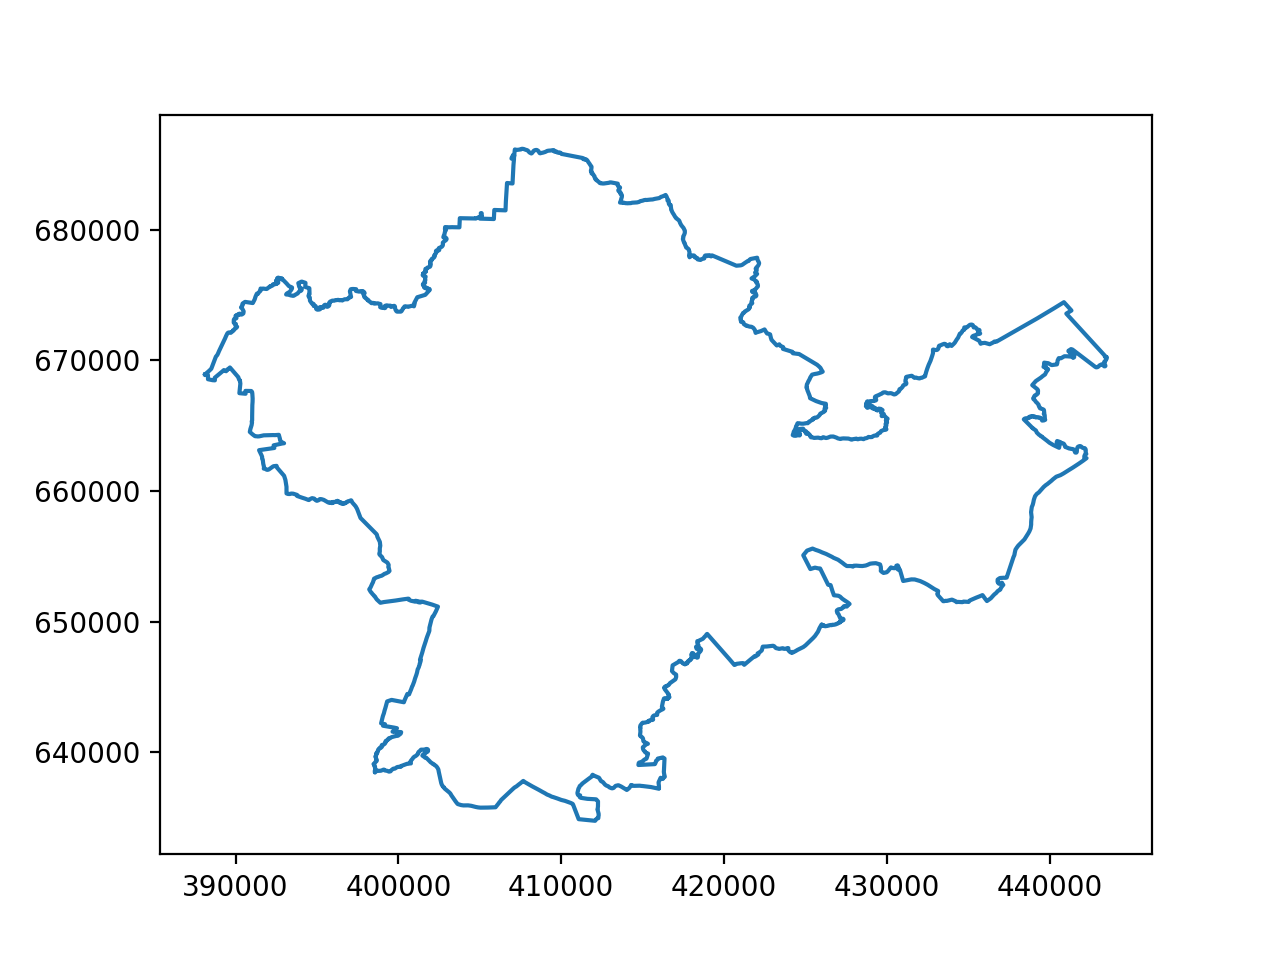

In [6]:
# Read and show county

vector_file = 'data/vector/powiat_chojnicki.shp'
vector_data = VectorData(vector_file)
vd = vector_data.get_vector_data('geometry', True)
vector_data.show_vector_data(vd)

In [15]:
# Get the destination crs from raster band

landsat_images = read_landsat_images(dataset['DIR'][0])
landsat_images

{1: 'data/rasters/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band1.tif',
 2: 'data/rasters/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band2.tif',
 3: 'data/rasters/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band3.tif',
 4: 'data/rasters/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band4.tif',
 5: 'data/rasters/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band5.tif',
 6: 'data/rasters/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band6.tif',
 7: 'data/rasters/LC081900232013080501T1-SC20180517172727/LC08_L1TP_190023_20130805_20170503_01_T1_sr_band7.tif'}

In [16]:
epsg = get_epsg_from_raster(landsat_images[5])

In [17]:
vn = vector_data.reproject_geometry(epsg, True)

In [19]:
file_for_clipped = 'data/clipped/clipped_test.tif'
clip_area(vn, landsat_images[5], file_for_clipped)

<IPython.core.display.Javascript object>


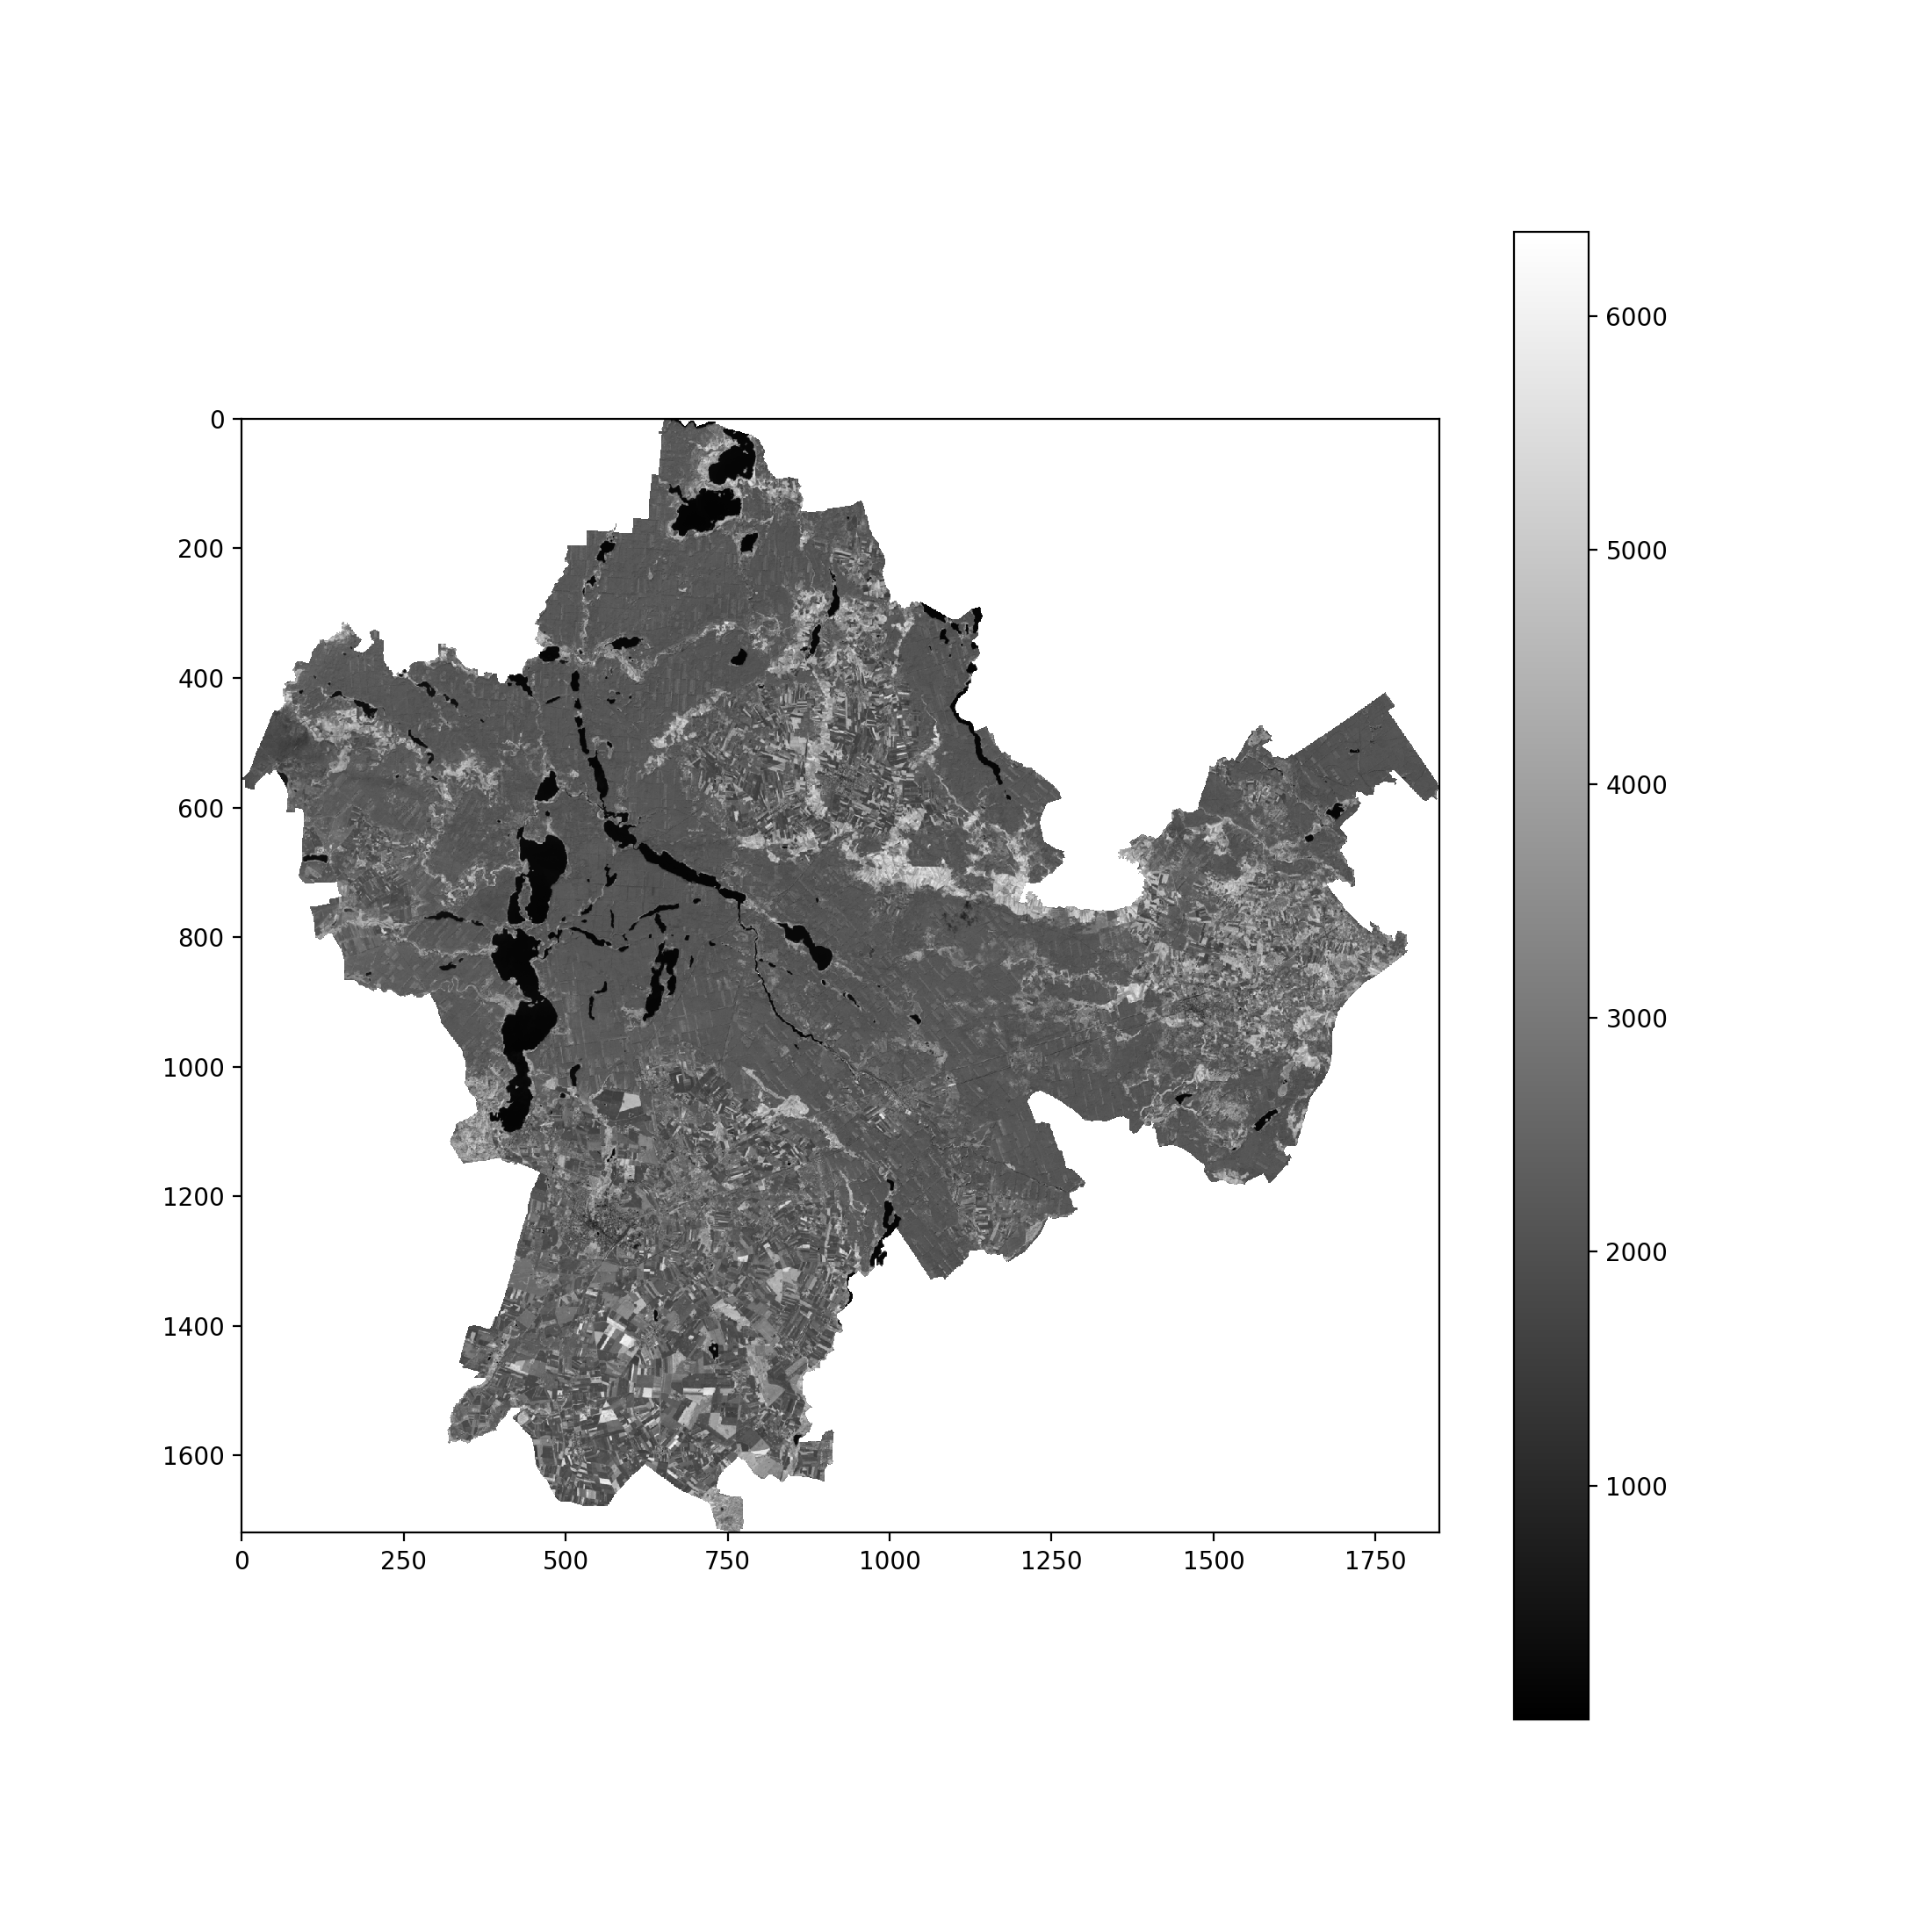

In [20]:
with rio.open(file_for_clipped) as f:
    band = f.read(1)
    band_crs = f.crs
    
show_band(band)

In [64]:
# Perform automatic clipping of bands 2, 4, 5 of each folder

def clip_all(df, clipping_vector, bands=(2, 3, 4), folder_name='clipped/'):
    data_range = len(dataset)
    damaged = []
    correct = []
    for i in range(0, data_range):
        date_str = str(dataset.index[i])
        images = read_landsat_images(dataset['DIR'][i])
        for band_number in bands:
            band_to_clip = images[band_number]
            filename = folder_name + 'LC_band' + str(band_number) + '_' + date_str + '.tif'
            try:
                clip_area(vn, band_to_clip, filename)
            except (rio.errors.WindowError, ValueError):
                print('Polygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.')
                damaged.append(filename)
                pass
            
            # Check file
            if filename in damaged:
                print('File: {} not saved. Raster has not been clipped.'.format(
                filename))
            else:
                try:
                    with rio.open(filename) as tf:
                         pass
                except rio.RasterioIOError:
                    raise IOError('File was: {} not saved successfully'.format(
                    filename))
                else:
                    print('File: {} saved successfully'.format(
                    filename))
                    correct.append(filename)
    return [correct, damaged]
            
my_bands = (2, 4, 5)
my_folder_name = 'data/clipped/'
prepared_files = clip_all(dataset, vn, my_bands, my_folder_name)

File: data/clipped/LC_band2_2013-08-05.tif saved successfully
File: data/clipped/LC_band4_2013-08-05.tif saved successfully
File: data/clipped/LC_band5_2013-08-05.tif saved successfully
File: data/clipped/LC_band2_2014-05-20.tif saved successfully
File: data/clipped/LC_band4_2014-05-20.tif saved successfully
File: data/clipped/LC_band5_2014-05-20.tif saved successfully
File: data/clipped/LC_band2_2014-07-07.tif saved successfully
File: data/clipped/LC_band4_2014-07-07.tif saved successfully
File: data/clipped/LC_band5_2014-07-07.tif saved successfully
Polygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.
File: data/clipped/LC_band2_2014-09-16.tif not saved. Raster has not been clipped.
Polygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.
File: data/clipped/LC_band4_2014-09-16.tif not saved. Ras